In [ ]:
# WIP, loading model from 4xV100 on 1xV100 box...

In [1]:
from __future__ import print_function, division
import os
import sys
import datetime

sys.path.insert(0,os.path.expanduser("deepfish"))
from deepfish.deep_skip import DeepSkip, train
Model = DeepSkip

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
# import apex # https://github.com/NVIDIA/apex.git
# from apex.amp import amp


import os, sys, datetime
import itertools
# LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
# FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
# FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
# sys.path.insert(0,LF_CODE_PATH)
# sys.path.insert(0,FT_CODE_PATH)
# sys.path.insert(0,FD_CODE_PATH)

# import passivity_2p_imaging_utils as p2putils
# reload(p2putils)
tmp_dir = '/tmp/'
# all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

# sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half

T.backends.cudnn.benchmark = True

# PARAMETERS
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
kl_lambda = 5e-4
sparse_lambda=1e-3
lr=1e-3
nepochs = 15
nEmbedding = 20
# batch_size = 6
batch_size = 32

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tifffile import imread
from glob import glob
import re

In [14]:
get_num = re.compile(".*_zplane=(\d*).tif")
get_z = lambda x: int(get_num.search(x).group(1))
tifs = glob("/data2/Data/f10542/*.tif")
tifs = sorted(tifs, key=lambda a: get_z(a))

In [16]:
nZ = len(tifs)

In [4]:
imaging = np.load("/data2/Data/f10542/f10542_small_imaging.npy")

In [29]:
mean_frame = imaging.mean(0)

In [19]:
nT, nZ, H, W = imaging.shape

small_imaging_fp32 = small_imaging.astype(np.float32)
np.save("/data2/Data/f10542/f10542_small_imaging_fp32.npy", small_imaging_fp32)

In [5]:
# H, W = (256, 256)
# imaging = pad_imaging(small_imaging,H, W)
# del small_imaging

np.save("/data2/Data/f10542/f10542_small_imaging.npy", imaging)

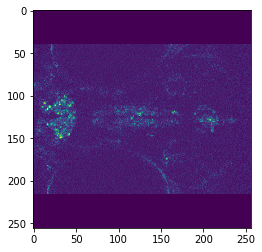

In [6]:
plt.imshow(imaging[0,0])

In [7]:
shocks = T.from_numpy(np.zeros(nT).astype(np.float32))
tail_movements = T.from_numpy(np.zeros(nT).astype(np.float32))

In [8]:
gc.collect()

28

In [9]:
# tvt_split = train_valid_test_split(2826, nchunks=20)
tvt_split = train_test_split(nT, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])


# LOAD TIFF
train_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

# all_data = ZebraFishData(imaging,shocks,tail_movements,None,
#                         prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape


# print("Number of tail movements in test: {}".format(np.array([float(x[1]["tail_movement"]) for x in test_data]).sum()))


# print("len(train_data): {}".format(len(train_data)))

# print("len(test_data): {}".format(len(test_data)))

['test: 200 (3.95%)', 'train: 4868 (96.05%)', 'validation: 0 (0.00%)']


In [10]:
del imaging

In [11]:
gc.collect()

0

In [6]:
from __future__ import print_function, division
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from volume import Vol2D
from resnet import ResNet, BasicBlock
from super_res import SuperResSkip
from torch.utils.data import DataLoader, Dataset
from misc import sigmoid_schedule
from tqdm import tqdm



class DeepSkip(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(DeepSkip, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 16
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 64
        self.nEmbedding = nEmbedding
        assert nEmbedding % 2 == 0

        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.nhalf_embed = int(self.nEmbedding/2)
        # Prediction
        self.pred1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Prediction
        self.predz1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.predz2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(self.nhalf_embed,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResSkip(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResSkip(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResSkip(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResSkip(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResSkip(2,tensor)
        # 11 x 256 x 512

        self.tail_decoding = nn.Linear(1,1)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)

    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        x = x.transpose(1,2)
        # X :: b x z x t x h x w
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
#                 print("layer_out "+k+" shape: "+ str(layer_out[k].shape))
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs

    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x

    def predictZero(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.predz1(x))
        x = self.predz2(x)
        return x

    def decode(self, x, layer_output):
        tail = T.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
#         tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail

    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_prev = self.predictZero(encoded[:,self.nhalf_embed:], shock)
        encoded_pred = self.predict(encoded[:,:self.nhalf_embed], shock)
        prev = self.decode(encoded_prev, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?

def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)

    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        i = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)

        avg_Y_loss = cum_Y_loss/len(train_data)
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), cum_X_loss/len(train_data), avg_Y_loss, cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))
#         cum_loss = 0
#         cum_X_loss = 0
#         cum_Y_loss = 0
#         cum_kld_loss = 0
#         cum_tail_loss = 0
#         model.eval()
#         gc.collect()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
#             if half:
#                 X_pred = X_pred.float()
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             kld = unit_norm_KL_divergence(mean, logvar)
#             mse_X = F.mse_loss(X_pred, Y[:,0])
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
#             loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
#             cum_loss += float(loss)
#             cum_X_loss += float(mse_X)
#             cum_Y_loss += float(mse_Y)
#             cum_kld_loss += float(kld)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_Y_loss, avg_Y_valid_loss


In [ ]:
3

In [ ]:
batch_size = 12
multi_gpu = False

tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames,next_frames, tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

# WARNING: TEST DATA BEING USED
avg_Y_loss, avg_Y_valid_loss = train(conv_model,train_data,test_data,nepochs,lr=lr, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)


T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

In [18]:
model_name = "/data2/trained_models/" + \
    "f15042_epoch=4_xloss=8.99e+1_yloss=1.05e+2"

In [16]:
T.save(conv_model.state_dict(),
       model_name+".pt")

In [ ]:
model = conv_model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [7]:
T.load("/data2/trained_models/f15042_epoch=4_xloss=8.99e+1_yloss=1.05e+2.pt")

RuntimeError: cuda runtime error (30) : unknown error at torch/csrc/cuda/Module.cpp:51

In [ ]:
"yo"

In [22]:
import skvideo

In [61]:
mean_frame_T = T.from_numpy(mean_frame).max(0)[0]

In [89]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0].max(0)[0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1].max(0)[0] - y[0].max(0)[0])
                frame[H:, W:(2*W)] = np.abs(y_pred.max(0)[0].cpu() - y[0].max(0)[0])
            else:
                frame[:H, W:(2*W)] = y[-1].max(0)[0] - y[0].max(0)[0]
                frame[H:, W:(2*W)] = y_pred.max(0)[0].cpu() - y[0].max(0)[0]
            frame[:H, (2*W):] = y[-1].max(0)[0] + mean_frame_T
            frame[H:, :W] = x_pred.max(0)[0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred.max(0)[0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0][13][0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1][13][0] - y[0][13][0])
                frame[H:, W:(2*W)] = np.abs(y_pred[13][0].cpu() - y[0][13][0])
            else:
                frame[:H, W:(2*W)] = y[-1][13][0] - y[0][13][0]
                frame[H:, W:(2*W)] = y_pred[13][0].cpu() - y[0][13][0]
            frame[:H, (2*W):] = y[-1][13][0] + mean_frame_T
            frame[H:, :W] = x_pred[13][0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred[13][0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [116]:
frame = makePredVideo(conv_model,test_data,
                      T.from_numpy(mean_frame)[13], False,
                      name=model_name+'_demean_z=13_test')

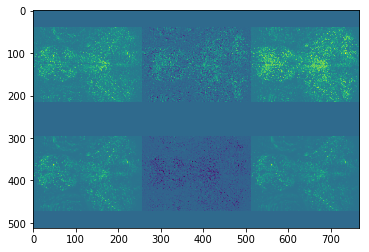

In [117]:
plt.imshow(frame)

In [72]:
mymin, mymax

(0.0, 1809.97119140625)

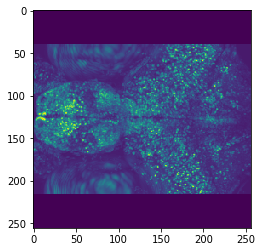

In [74]:
plt.imshow(scale_for_vid(mean_frame_T.numpy(), mymin, mymax))

In [31]:
del imaging